In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#!pip3 install tensorflow
import tensorflow as tf
import tensorflow.keras

In [2]:
df = pd.read_csv("data/stp_lm.csv")
df.dropna(inplace=True)
df.head(10)

,Tweet,Label
0,little throwback favourite person water wall,0
1,glam yesterday kcon makeup featherette,7
2,democracy plaza wake stunning outcome decision...,11
3,amp vilo walt disney magic kingdom,0
4,galaxy far far away,2
5,dinner fla tonight panseared salmon couscous...,1
6,fav senior game congrats beating west west s...,8
7,got formal best friend phi mu jsu,0
8,cause miss little homies throwback cousinlove ...,13
9,birthday kiss madison wisconsin,9


In [3]:
 df.drop_duplicates(inplace=True)
print('after drop duplicates', df.shape)

after drop duplicates (49823, 2)


In [4]:
df['Tweet'] = df['Tweet'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ')
df.head(10)
df.shape

/var/folders/p6/9vz93_jn0w35pcs_knjyd76r0000gn/T/ipykernel_98456/3291048459.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Tweet'] = df['Tweet'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ')


(49823, 2)

In [65]:
#################### VECTORIZATION CV ##################

In [ ]:
#################### VECTORIZATION CV END ##################

In [66]:
X=df["Tweet"].values
y=df["Label"].values

In [67]:
from sklearn.model_selection import train_test_split

#X_train, X_test ,y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=101)
X_train, X_test ,y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=101, stratify=y,shuffle = True)

In [68]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((42349,), (42349,), (7474,), (7474,))

In [69]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
os = RandomOverSampler()
X_train = X_train.reshape(-1,1)
#os = SMOTE(random_state=42)
X_train,y_train = os.fit_resample(X_train, y_train)
X_train = X_train.reshape(-1,)
X_train.shape

(182120,)

In [70]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((182120,), (182120,), (7474,), (7474,))

In [71]:
####### TOKENIZER #######

In [72]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=80000)
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)

In [73]:
print("Text \n",X[:10],'\n')

X_train_seqs = tokenizer.texts_to_sequences(X_train)
X_test_seqs = tokenizer.texts_to_sequences(X_test)
print("Sequences")
X_train_seqs[:10]

Text 
 ['little throwback favourite person water wall'
 'glam yesterday kcon makeup featherette'
 'democracy plaza wake stunning outcome decision nbc news'
 'amp vilo walt disney magic kingdom' ' galaxy far far away'
 'dinner fla tonight panseared salmon couscous veggie salad yum dinner florida salmon'
 'fav senior game congrats beating west west salem'
 'got formal best friend phi mu jsu'
 'cause miss little homies throwback cousinlove indiana university'
 'birthday kiss madison wisconsin'] 

Sequences


[[30965, 1156, 7],
 [48, 442, 38981, 231, 6164, 148, 1095],
 [77, 10523, 21, 4725, 2151, 166, 700],
 [6694, 194, 182, 41, 107, 1789],
 [38982, 30, 3, 38983, 38984, 1610, 148, 34578],
 [377, 39, 2201, 4365, 2656, 1229, 1808, 132, 47, 2657],
 [28, 541, 666, 3, 104, 429, 3203, 715, 62, 724, 715, 298],
 [350, 260, 4255, 48, 126],
 [1254, 70, 7015, 3323],
 [701, 622, 30966, 8820, 3593, 3805, 1068]]

In [74]:
vocab_size = len(tokenizer.index_word)
print("Vocabulary size :",len(tokenizer.index_word))

Vocabulary size : 54401


In [75]:
from keras_preprocessing.sequence import pad_sequences

max_len=40
X_train_seqs_pd = pad_sequences(X_train_seqs, truncating="pre", padding="pre", maxlen=max_len)
X_test_seqs_pd = pad_sequences(X_test_seqs, truncating="pre", padding="pre", maxlen=max_len)


In [76]:
X_train = X_train_seqs_pd
X_test = X_test_seqs_pd

In [77]:
############## LSTM ###############

In [78]:
from keras.models import Sequential
from keras.layers import Dropout, Dense, LSTM, Bidirectional,Embedding, GlobalMaxPool1D



vocabulary_size = vocab_size
seq_len = 40
embed_len=20

model = Sequential()
model.add(Embedding(vocabulary_size+1, embed_len, input_length=seq_len))
model.add(LSTM(units = 80, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(units = 40))
model.add(Dropout(0.5))
model.add(Dense(units=20, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 40, 20)            1088040   
                                                                 
 lstm_2 (LSTM)               (None, 40, 80)            32320     
                                                                 
 dropout_2 (Dropout)         (None, 40, 80)            0         
                                                                 
 lstm_3 (LSTM)               (None, 40)                19360     
                                                                 
 dropout_3 (Dropout)         (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 20)                820       
                                                                 
Total params: 1,140,540
Trainable params: 1,140,540
No

In [98]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=3,verbose=3)

model.compile(loss = 'categorical_crossentropy',
             optimizer = "adam",
             metrics=["accuracy"])

In [99]:
from keras.utils import to_categorical

y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

In [100]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, y_train_cat.shape, y_test_cat.shape

((182120, 40), (7474, 40), (182120,), (7474,), (182120, 20), (7474, 20))

In [101]:
batch_size=128
epochs = 20

model.fit(X_train, y_train_cat, batch_size=batch_size, epochs = epochs, shuffle=True,
          validation_data=(X_test, y_test_cat), callbacks=[early_stop])

Epoch 1/20
1423/1423 [==============================] - 166s 113ms/step - loss: 0.7972 - accuracy: 0.7837 - val_loss: 3.8598 - val_accuracy: 0.1801
Epoch 2/20
1423/1423 [==============================] - 152s 107ms/step - loss: 0.6345 - accuracy: 0.8254 - val_loss: 4.3195 - val_accuracy: 0.1880
Epoch 3/20
1423/1423 [==============================] - 146s 102ms/step - loss: 0.5288 - accuracy: 0.8532 - val_loss: 4.6547 - val_accuracy: 0.1895
Epoch 4/20
1423/1423 [==============================] - 173s 121ms/step - loss: 0.4498 - accuracy: 0.8764 - val_loss: 5.1029 - val_accuracy: 0.1891
Epoch 4: early stopping


In [102]:
model.evaluate(X_test, y_test_cat, batch_size=batch_size)

59/59 [==============================] - 2s 37ms/step - loss: 5.1029 - accuracy: 0.1891


[5.102876663208008, 0.189055398106575]

In [103]:
loss = pd.DataFrame(model.history.history)
loss

""


In [104]:
from sklearn.metrics import classification_report, confusion_matrix

y_predict = np.argmax(model.predict(X_test), axis=-1)

#predict_x = model.predict(X_test)
#classes_x=np.argmax(predict_x,axis=1)
print(classification_report(y_test, y_predict))

234/234 [==============================] - 5s 16ms/step
              precision    recall  f1-score   support

           0       0.31      0.29      0.30      1607
           1       0.14      0.16      0.15       789
           2       0.30      0.29      0.30       783
           3       0.10      0.11      0.10       432
           4       0.29      0.23      0.26       377
           5       0.08      0.07      0.08       346
           6       0.08      0.07      0.07       306
           7       0.13      0.17      0.15       282
           8       0.08      0.10      0.09       268
           9       0.10      0.09      0.10       250
          10       0.10      0.08      0.09       231
          11       0.39      0.36      0.37       228
          12       0.22      0.23      0.23       219
          13       0.08      0.07      0.08       202
          14       0.06      0.05      0.05       206
          15       0.07      0.09      0.08       187
          16       0.03  

Normalized confusion matrix


<Figure size 1500x1500 with 0 Axes>

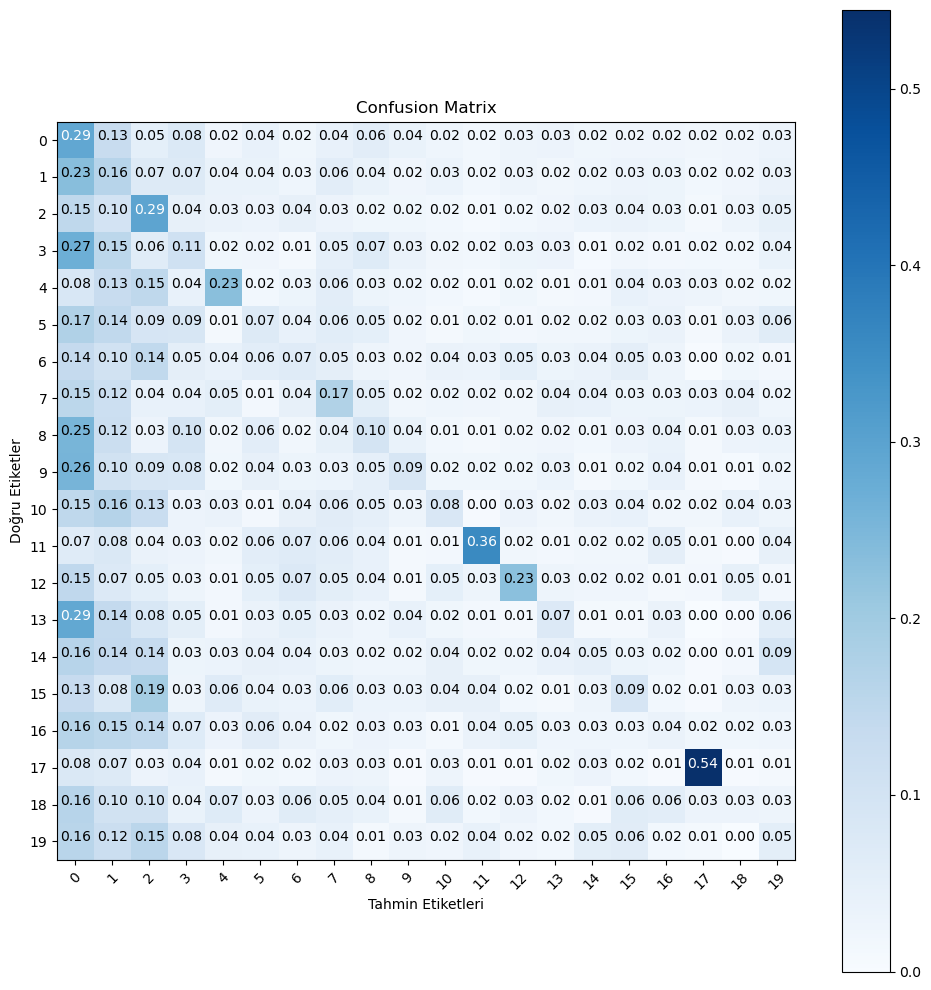

In [108]:
plt.figure(figsize=(15,15))
result = confusion_matrix(y_test, y_predict)
plot_confusion_matrix(result, [i for i in range(20)] ,title='Confusion Matrix', normalize=True)

